In [21]:
# Imports
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
# Create output dir
out_dir = Path("notebooks/output")
out_dir.mkdir(parents=True, exist_ok=True)

In [22]:
# Load draw_stats.json (produced by the harness)
stats_path = Path("../draw_stats.json")
if not stats_path.exists():
    raise FileNotFoundError(f"Expected {stats_path} in repo root — run the harness first")
with open(stats_path, "r") as fh:
    stats = json.load(fh)
total_runs = stats.get("total_runs")
teams_data = stats["teams"]
# Build DataFrames: group_df (teams x groups) and pair_df (teams x teams)
group_df = pd.DataFrame({t: teams_data[t]["group_pct"] for t in teams_data}).T.fillna(0)
pair_df = pd.DataFrame({t: teams_data[t]["pair_pct"] for t in teams_data}).T.fillna(0)
# Sort columns/indices for reproducible layout
group_df = group_df.reindex(sorted(group_df.index))
group_df = group_df[sorted(group_df.columns)]
pair_df = pair_df.reindex(index=sorted(pair_df.index), columns=sorted(pair_df.columns))
print("Loaded", len(group_df), "teams, total_runs =", total_runs)

Loaded 48 teams, total_runs = 99998


Saved notebooks/output/group_occupancy_heatmap_log.png


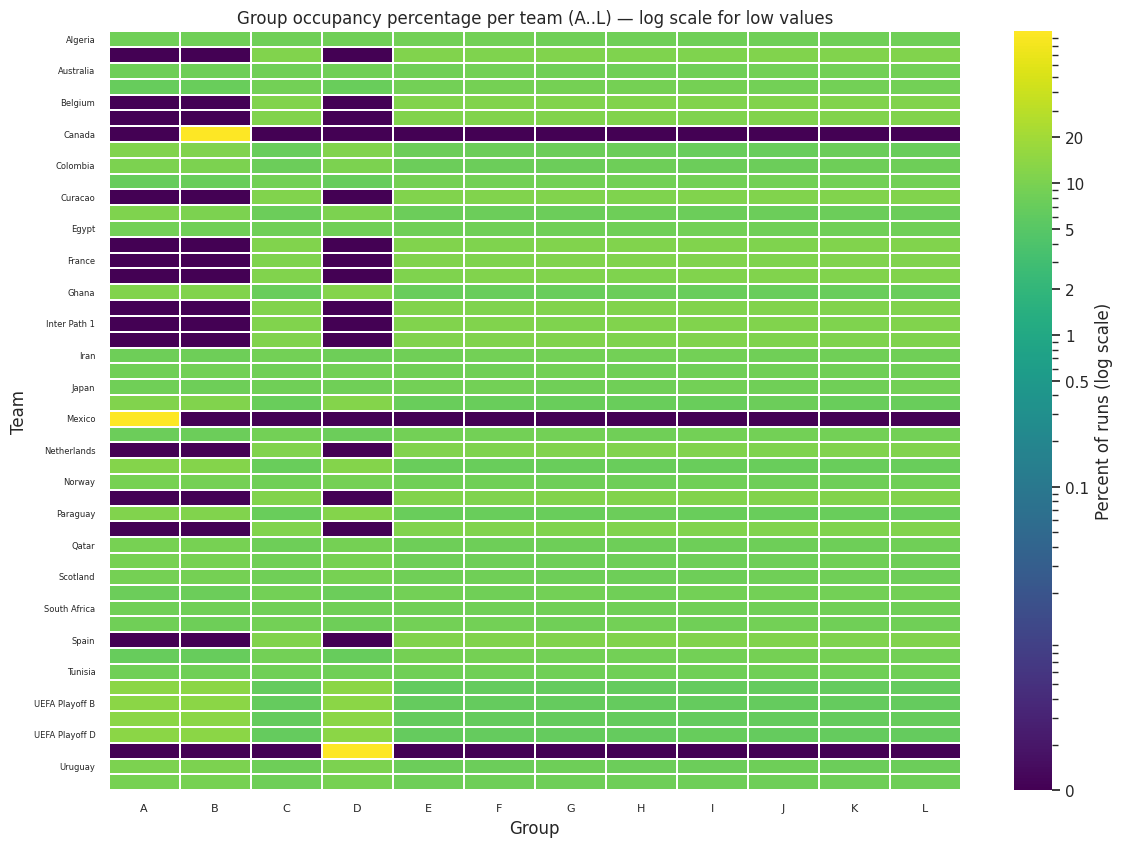

In [23]:
# Heatmap: group occupancy (teams x groups) — higher resolution for low percentages
plt.figure(figsize=(12, max(6, 0.18 * len(group_df))))
from matplotlib.colors import LogNorm

# Use a log scale to increase contrast between low percentages (0-20%)
# Replace zeros with a tiny epsilon so LogNorm can be applied, but label them as 0 on the colorbar
eps = 1e-3
data = group_df.copy().replace(0.0, eps)
vmax = max(20.0, float(data.max().max()))
norm = LogNorm(vmin=eps, vmax=vmax)
ax = sns.heatmap(
    data,
    cmap="viridis",
    norm=norm,
    cbar_kws={"label": "Percent of runs (log scale)"},
    linewidths=0.05,
)
ax.set_xlabel("Group")
ax.set_ylabel("Team")
ax.set_title("Group occupancy percentage per team (A..L) — log scale for low values")
# Reduce y-axis label size so long team names fit
ax.tick_params(axis="y", labelsize=6)
ax.tick_params(axis="x", labelsize=8)
# Make the colorbar ticks human-friendly and show 0 as a label for the epsilon
cbar = ax.collections[0].colorbar
ticks = [eps, 0.1, 0.5, 1, 2, 5, 10, 20]
ticks = [t for t in ticks if t <= vmax]
cbar.set_ticks(ticks)
cbar.set_ticklabels(["0" if t == eps else str(t) for t in ticks])
plt.tight_layout()
out_file = out_dir / "group_occupancy_heatmap_log.png"
plt.savefig(out_file, dpi=150)
print("Saved", out_file)
plt.show()

Wrote notebooks/output/Scotland_opponents.csv


/tmp/ipykernel_63272/1797502914.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.values, y=data.index, palette='mako')


Saved notebooks/output/Scotland_opponents_bar.png


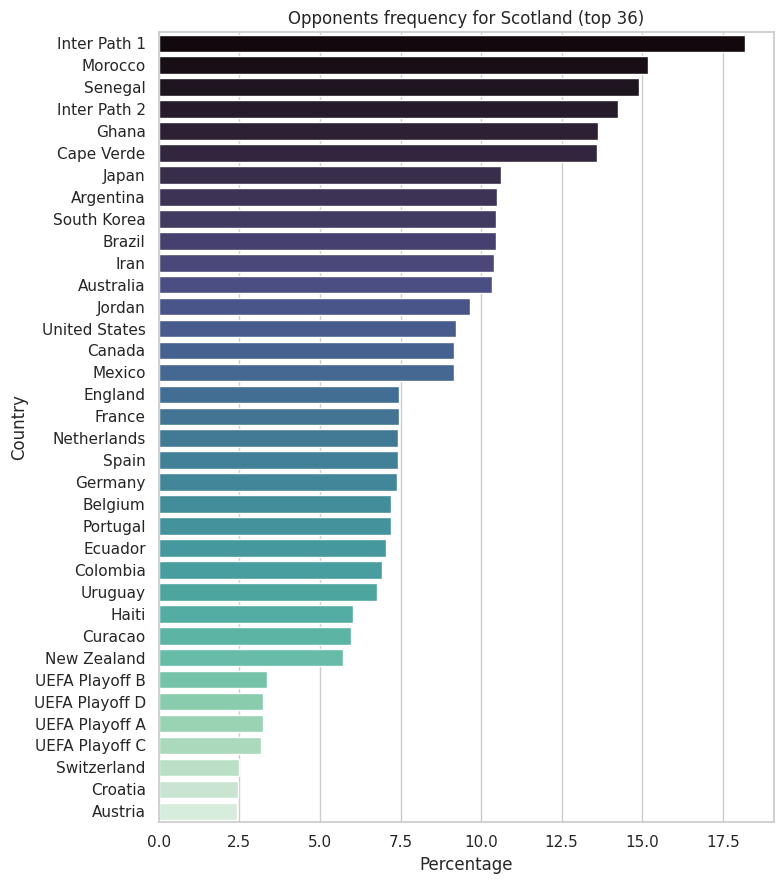

In [27]:
# Scotland opponents: CSV and bar chart
team = "Scotland"
if team not in pair_df.index:
    raise ValueError(f"{team} not found in pair_df")
scot = pair_df.loc[team].sort_values(ascending=False)
# Keep only non-zero entries for clarity
scot_nonzero = scot[scot > 0]
if scot_nonzero.empty:
    print("No recorded opponents for", team)
else:
    # Save CSV of opponents (opponent, pct)
    scot_out = out_dir / f"{team.replace(' ', '_')}_opponents.csv"
    df = scot_nonzero.reset_index()
    df.columns = ["opponent", "pct"]
    df.to_csv(scot_out, index=False)
    print("Wrote", scot_out)
    # Plot top-N opponents (default top 20)
    topn = 48
    data = scot_nonzero.head(topn)
    plt.figure(figsize=(8, max(4, 0.25 * len(data))))
    sns.barplot(x=data.values, y=data.index, palette="mako")
    plt.xlabel("Percentage")
    plt.ylabel("Country")
    plt.title(f"Opponents frequency for {team} (top {min(topn, len(data))})")
    plt.tight_layout()
    out_file = out_dir / f"{team.replace(' ', '_')}_opponents_bar.png"
    plt.savefig(out_file, dpi=150)
    print("Saved", out_file)
    plt.show()

Wrote top-10 pairings CSV to notebooks/output/top10_pairings.csv


/tmp/ipykernel_63272/2224713713.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pct', y=top10.apply(lambda r: r['team1'] + ' — ' + r['team2'], axis=1), data=top10, palette='rocket')


Saved notebooks/output/top10_pairings.png


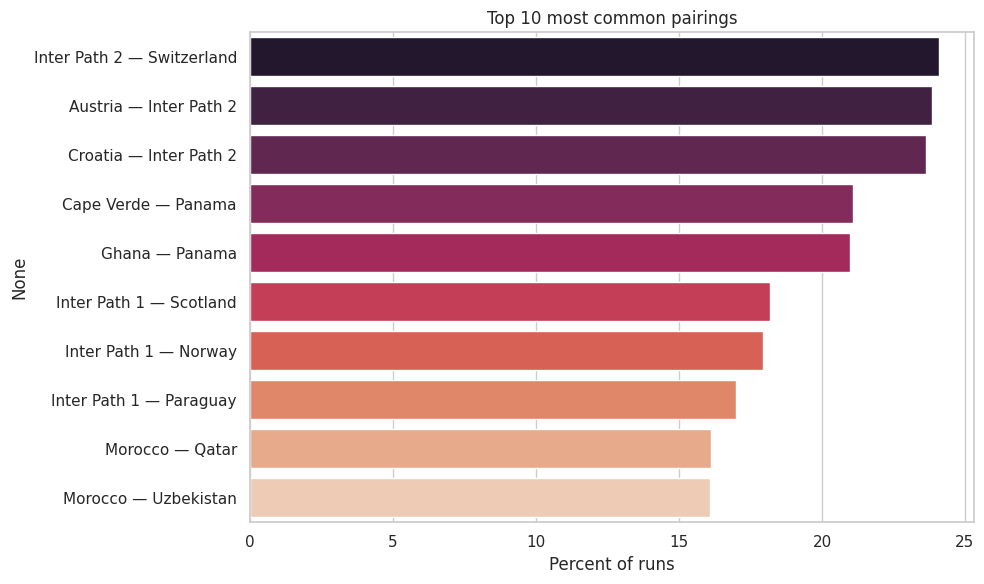

Wrote bottom-10 pairings CSV to notebooks/output/bottom10_pairings.csv


/tmp/ipykernel_63272/2224713713.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pct', y=bottom10.apply(lambda r: r['team1'] + ' — ' + r['team2'], axis=1), data=bottom10, palette='mako')


Saved notebooks/output/bottom10_pairings.png


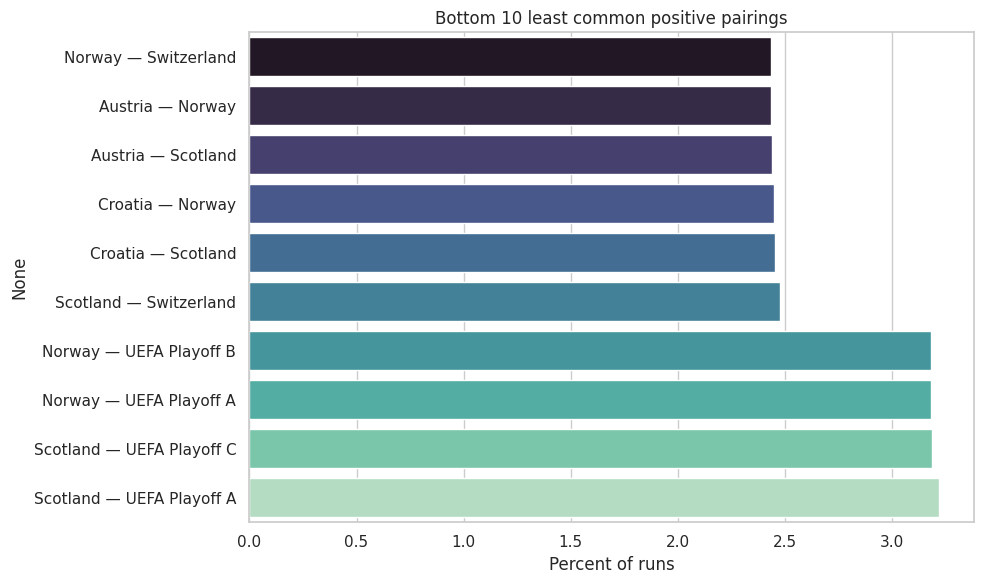

In [25]:
# Top 10 most and least common pairings (excluding 0%)
# Build unique undirected pairs from pair_df by taking upper triangle averages
teams = list(pair_df.index)
pairs = []
for i in range(len(teams)):
    for j in range(i + 1, len(teams)):
        t1 = teams[i]
        t2 = teams[j]
        # average both directions to be robust against tiny asymmetries
        v1 = pair_df.loc[t1, t2] if t2 in pair_df.columns else 0.0
        v2 = pair_df.loc[t2, t1] if t1 in pair_df.columns else 0.0
        pct = float((v1 + v2) / 2.0)
        if pct > 0.0:
            pairs.append({"team1": t1, "team2": t2, "pct": pct})
pairs_df = pd.DataFrame(pairs)
if pairs_df.empty:
    print("No non-zero pairings found in pair_df")
else:
    # Top 10 most common pairings
    top10 = pairs_df.sort_values("pct", ascending=False).head(10).reset_index(drop=True)
    top10_out = out_dir / "top10_pairings.csv"
    top10.to_csv(top10_out, index=False)
    print("Wrote top-10 pairings CSV to", top10_out)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="pct",
        y=top10.apply(lambda r: r["team1"] + " — " + r["team2"], axis=1),
        data=top10,
        palette="rocket",
    )
    plt.xlabel("Percent of runs")
    plt.title("Top 10 most common pairings")
    plt.tight_layout()
    out_img = out_dir / "top10_pairings.png"
    plt.savefig(out_img, dpi=150)
    print("Saved", out_img)
    plt.show()
    # Bottom 10 least common positive pairings
    bottom10 = pairs_df.sort_values("pct", ascending=True).head(10).reset_index(drop=True)
    bottom10_out = out_dir / "bottom10_pairings.csv"
    bottom10.to_csv(bottom10_out, index=False)
    print("Wrote bottom-10 pairings CSV to", bottom10_out)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="pct",
        y=bottom10.apply(lambda r: r["team1"] + " — " + r["team2"], axis=1),
        data=bottom10,
        palette="mako",
    )
    plt.xlabel("Percent of runs")
    plt.title("Bottom 10 least common positive pairings")
    plt.tight_layout()
    out_img2 = out_dir / "bottom10_pairings.png"
    plt.savefig(out_img2, dpi=150)
    print("Saved", out_img2)
    plt.show()

Processing Inter Path 1
Wrote notebooks/output/Inter_Path_1_opponents.csv


/tmp/ipykernel_63272/332710029.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.values, y=plot_data.index, palette='viridis')


Saved notebooks/output/Inter_Path_1_opponents_bar.png


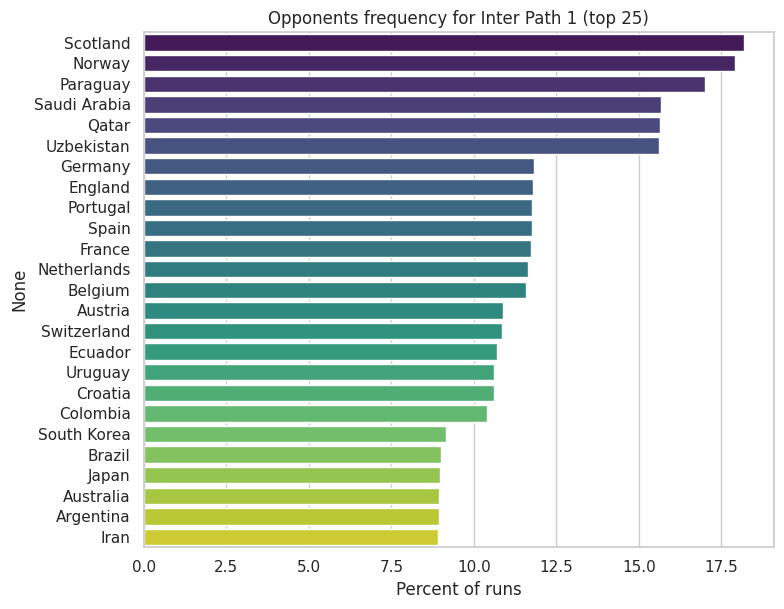

Processing Inter Path 2
Wrote notebooks/output/Inter_Path_2_opponents.csv


/tmp/ipykernel_63272/332710029.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.values, y=plot_data.index, palette='viridis')


Saved notebooks/output/Inter_Path_2_opponents_bar.png


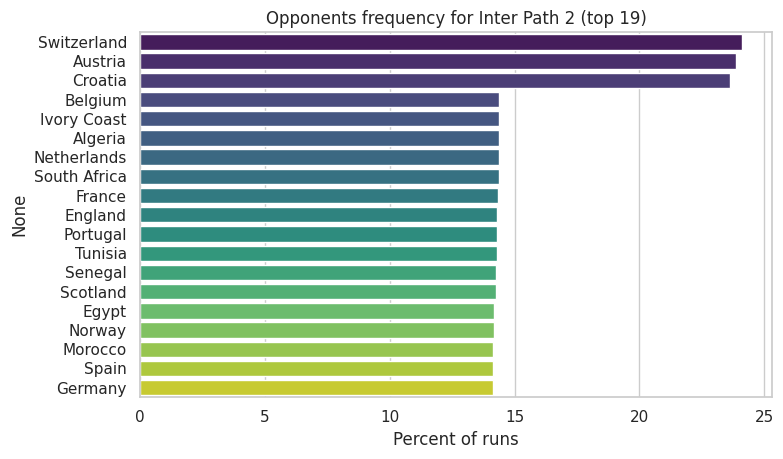

In [26]:
# Visualize opponents for Inter Path 1 and Inter Path 2
for team in ["Inter Path 1", "Inter Path 2"]:
    print("Processing", team)
    if team not in pair_df.index:
        print(f"{team} not present in pair_df; skipping")
        continue
    vec = pair_df.loc[team].sort_values(ascending=False)
    vec_nonzero = vec[vec > 0]
    if vec_nonzero.empty:
        print("No recorded opponents for", team)
        continue
    out_csv = out_dir / f"{team.replace(' ', '_')}_opponents.csv"
    df_out = vec_nonzero.reset_index()
    df_out.columns = ["opponent", "pct"]
    df_out.to_csv(out_csv, index=False)
    print("Wrote", out_csv)
    # Plot all non-zero opponents (or cap to top 40 for readability)
    cap = 40
    plot_data = vec_nonzero.head(cap)
    plt.figure(figsize=(8, max(4, 0.25 * len(plot_data))))
    sns.barplot(x=plot_data.values, y=plot_data.index, palette="viridis")
    plt.xlabel("Percent of runs")
    plt.title(f"Opponents frequency for {team} (top {min(cap, len(plot_data))})")
    plt.tight_layout()
    out_img = out_dir / f"{team.replace(' ', '_')}_opponents_bar.png"
    plt.savefig(out_img, dpi=150)
    print("Saved", out_img)
    plt.show()

## Next steps
- If the large JSONL arrives, we can add a small aggregator cell to consume it and append to `draw_stats.json` or produce a new aggregated file.
- We can also produce interactive dashboards (Plotly/Altair) or export a few selected PNGs for reporting.
- Tell me which team(s) or pairings you'd like highlighted and I will add dedicated plots.